# Emergence of teams
Version: 2022-04-19 - Authors: Guillaume Dumas, Maximilian Puelma Touzel

## Random policy generation

In [1]:
import numpy as np
from tqdm import tqdm, trange
import pylab as pl
# For each timepoint, each agent can choose to do action 0, action 1, ..., or action (n_actions)
# The next action is function of the last (n_memory) actions of all agents i.e. (n_actions ** (n_agents * n_memory)) possibilities
# The policy of the (n_agents) agent can be set to fully random, with beta=0, to identical to all the other agents of the same team, with beta=1
# For each team, the subselection of (beta * n_states) actions are taken as a similar random choice for each team.

## Wrapped version

In [10]:
def get_mix_policies(avg_pairwise_correlation, n_teams, team_size, policy_seed, n_actions = 2):
    n_agents = n_teams*team_size
    n_states = n_actions ** (n_agents +1) #add states of agent 1
    policies = np.zeros((n_agents, n_states),dtype=bool)
    
    rng = np.random.default_rng(policy_seed)
    agent_indices_bool = np.zeros(n_agents,dtype=bool)
    
    for team in range(n_teams):
        agent_indices = range(team * team_size, (team+1) * team_size)
        agent_indices_bool[agent_indices]=True
        #joint actions for a group are assigned Bernoulli: {as same over the group, else random}
        is_same = (avg_pairwise_correlation > rng.random(n_states)) #TODO: add more than binary ations is_same=(avg_pairwise_correlation>np.random.rand(0, n_actions, n_states)) #joint actions for a group are assigned as same over the group, else random
        n_same = np.sum(is_same)
        n_diff = n_states-n_same
        policies[np.ix_(agent_indices_bool, is_same)] = rng.integers(0, n_actions, n_same)[np.newaxis,:]
        policies[np.ix_(agent_indices_bool, ~is_same)] = rng.integers(0, n_actions, [team_size,n_diff])
        agent_indices_bool[agent_indices] = False 
    return policies

def get_sum_policies(avg_pairwise_correlation, n_teams, team_size, policy_seed, n_actions = 2):
    n_agents = n_teams*team_size
    n_states = n_actions ** (n_agents +1) #add states of agent 1
    policies = np.zeros((n_agents, n_states),dtype=bool)
    
    rng = np.random.default_rng(policy_seed)
    agent_indices_bool = np.zeros(n_agents, dtype=bool)
    
    rho=np.sin(np.pi/2*avg_pairwise_correlation)
    for team in range(n_teams):
        agent_indices = range(team * team_size, (team+1) * team_size)
        agent_indices_bool[agent_indices]=True
        policies[agent_indices_bool, :] = ((np.sqrt(1 - rho)*rng.normal(size = (team_size, n_states)) + np.sqrt(rho)*rng.normal(size = n_states)[np.newaxis,:]) > 0)
        agent_indices_bool[agent_indices] = False
    return policies

def binary2index(var, n_all_agents = 25):
    assert len(var)==n_all_agents, "incorrectly sized tuple"
    return np.sum([2**n for n in range(len(var))] * var).astype(int)

def index2binary(var):
#     return np.fromstring(np.binary_repr(156,width=25), dtype=np.uint8)==49
    return np.array([int(x) for x in list(('{0:0'+str(25)+'b}').format(var))],dtype=bool)

def iterate_n_steps(policies, initial_joint_action,n_steps):

    past_index = binary2index(initial_joint_action) 
    index_seq = np.zeros(n_steps, dtype=np.int64)    # generate the simulation
    for t in range(n_steps):
        index_seq[t] = past_index
        joint_action = policies[:, past_index]
        past_index = binary2index(joint_action)
    return index_seq

def get_corr_matrix(policies, index_seq):
    n_steps = len(index_seq)
    sims = policies[:,index_seq].T
    n_agents = policies.shape[0]
    corr_matrix = np.zeros([n_agents]*2)
    for i in range(n_agents):
        for j in range(n_agents):
            if i < j:
                corr_matrix[i,j] = 2*np.sum(sims[:, i] == sims[:, j])/n_steps - 1
    return corr_matrix + corr_matrix.T + np.identity(n_agents)

def simulate():
    n_teams = 2#5
    team_size = 12
    n_other_agents = n_teams*team_size
    n_all_agents = n_other_agents + 1

    n_states = 2 ** n_all_agents #for binary actions
    n_corr_values = 5
    n_steps = 10000

    agent_1_seed = 2
    rng = np.random.default_rng(agent_1_seed)
    agent_1_policy = rng.integers(0, 2, n_states)

    initial_state_seed = 3
    rng = np.random.default_rng(initial_state_seed)
    initial_joint_action=rng.integers(0, 2, n_all_agents)
    
    other_policies_seed = 12345
    corr_matrices = {}
    joint_action_seqs = {}
    joint_prob_matrices = {}
    binomvec=[tcomb(n_all_agents,k) for k in range(n_all_agents+1)]
    Cind = np.insert(np.cumsum(binomvec),0,0)
    for rit in trange(n_corr_values+1):
        rho = rit/n_corr_values
        data = []
        joint_store = []
        for get_policies in (get_mix_policies,get_sum_policies):
            other_agent_policies = get_policies(rho, n_teams, team_size, other_policies_seed)
            policies = np.vstack((agent_1_policy, other_agent_policies))
#             if False:#compute transition prob in C
#                 joint_Cprime_C=np.zeros((n_all_agents, n_all_agents))
#                 for C in range(n_agents+1):
#                     counts,bins = np.histogram(policies[:, Cind[C]:Cind[C+1]+1].sum(axis=0), bins=np.arange(0,n_agents+2))
#                     joint_Cprime_C[:,C] = counts
#                 joint_store.append(joint_Cprime_C)
            
            index_seq = iterate_n_steps(policies, initial_joint_action, n_steps)

            data.append(get_corr_matrix(policies, index_seq))

        corr_matrices[rho] = data
#         if False:
#             joint_prob_matrices[rho] = joint_store
    return corr_matrices

from scipy.special import comb
def tcomb(n,k):
    return comb(n,k,exact=True)

### Simulate

In [11]:
corr_matrices=simulate()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:23<00:00, 23.93s/it]


Text(0, 0.5, 'Sum dist.')

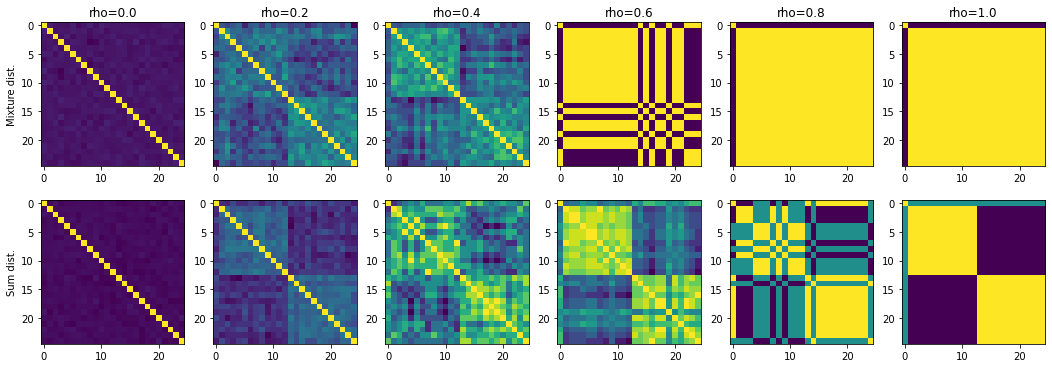

In [12]:
fig,ax=pl.subplots(2,6,figsize=(18,6))
for rit, rho in enumerate(corr_matrices.keys()):
    ax[0,rit].set_title(f'rho={rho}')
    for cit, corr_matrix in enumerate(corr_matrices[rho]):
        ax[cit,rit].imshow(corr_matrix)
ax[0,0].set_ylabel('Mixture dist.')
ax[1,0].set_ylabel('Sum dist.')
# fig.savefig('corr_matrices.pdf', transparent=True,bbox_inches="tight",dpi=300)

Text(0, 0.5, 'Heterogeneous')

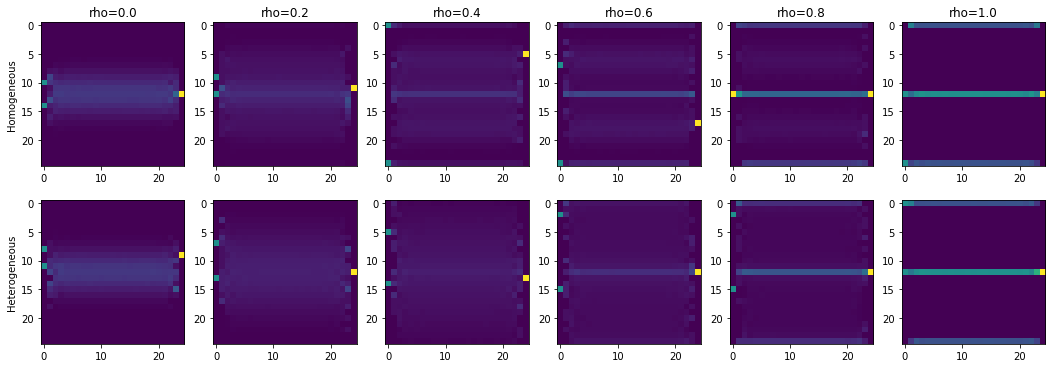

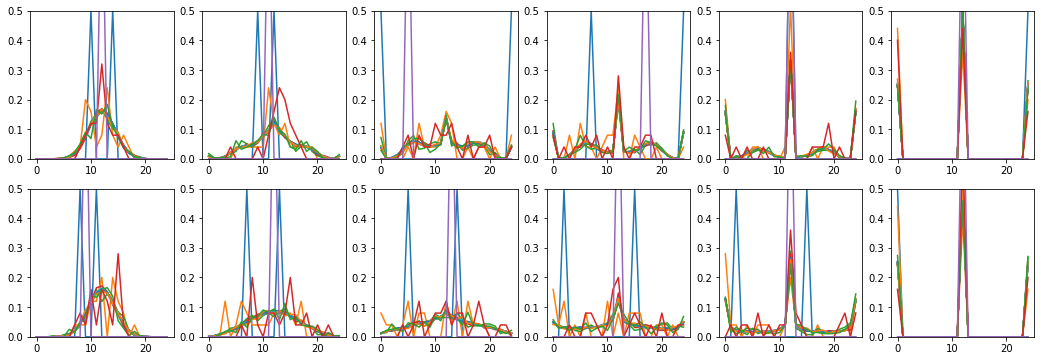

In [71]:
fig,ax=pl.subplots(2,6,figsize=(18,6))
fig2,ax2=pl.subplots(2,6,figsize=(18,6))
for rit, rho in enumerate(joint_prob_matrices.keys()):
    ax[0,rit].set_title(f'rho={rho}')
    for cit, joint_matrix in enumerate(joint_prob_matrices[rho]):
        joint_matrix/=np.sum(joint_matrix)
        conditional_prob=joint_matrix/np.sum(joint_matrix,axis=0)[np.newaxis,:]
        ax[cit,rit].imshow(conditional_prob)
        ax2[cit,rit].plot(conditional_prob)
        ax2[cit,rit].set_ylim(0,0.5)
ax[0,0].set_ylabel('Homogeneous')
ax[1,0].set_ylabel('Heterogeneous')

Count properties

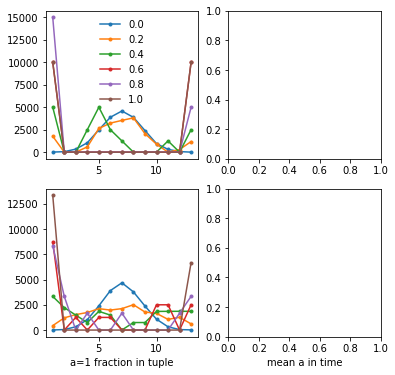

In [8]:
fig,ax=pl.subplots(2,2,figsize=(6,6))
for rit, rho in enumerate(joint_action_seqs.keys()):
#     ax[0,rit].set_title(f'rho={rho}')
    for cit, data in enumerate(joint_action_seqs[rho]):
        counts, bins=np.histogram(np.sum(data.reshape([n_steps,n_teams,int(n_agents/n_teams)]),axis=2).flatten(),np.arange(n_agents/n_teams+2))
        ax[cit,0].plot(bins[1:],counts,'.-',label=f'{rho}')
#     for cit, data in enumerate(joint_action_seqs[rho]):
#         counts, bins=np.histogram(np.mean(data,axis=0),np.arange(n_agents+1)/n_agents)
#         ax[cit,1].plot(bins[1:],counts,'.-',label=f'{rho}')
#     for cit, data in enumerate(joint_action_seqs[rho]):
#         counts, bins=np.histogram(np.sum(data,axis=1),np.arange(n_agents+1))
#         ax[cit,0].plot(bins[1:]/n_agents,counts,'.-',label=f'{rho}')
#     for cit, data in enumerate(joint_action_seqs[rho]):
#         counts, bins=np.histogram(np.mean(data,axis=0),np.arange(n_agents+1)/n_agents)
#         ax[cit,1].plot(bins[1:],counts,'.-',label=f'{rho}')
ax[1,0].set_xlabel('a=1 fraction in tuple')
ax[1,1].set_xlabel('mean a in time')
ax[0,0].legend(frameon=False)

In [18]:
# visualize the simulation
plt.figure(figsize=(50, 3))
plt.pcolor(sims.T)
plt.grid('on', color='k')
plt.tight_layout()
plt.savefig(f"{rho}.png")

NameError: name 'plt' is not defined

# Deprecated non-wrapped version

### Homogeneous case

Old method: (fixed fraction of actions)

In [3]:
# # initialize agents with random policies
# policies = np.zeros((n_agents, n_states))
# for agent in trange(n_agents):
#    policies[agent, :] = np.random.randint(0, n_actions, n_states)
# policies[0, :]
# # copy fraction of policies for each team
# team_size = int(n_agents/n_teams)
# n_similar_actions = int(n_states * beta)

# for team in trange(n_teams):
#     team_index = range(team * team_size, (team+1) * team_size)
#     similar_action_index = np.random.permutation(n_states)[:n_similar_actions]
#     for agent in team_index:
#         policies[agent, similar_action_index] = policies[team_index[0], :][similar_action_index]

# policies[team_index, :][:, similar_action_index].shape

New method: (variable fraction of actions, fixed mean)

In [4]:
policies = np.zeros((n_agents, n_states),dtype=bool)
team_size = int(n_agents/n_teams)
rng = np.random.default_rng(12345)
agent_indices_bool = np.zeros(n_agents,dtype=bool)
for team in trange(n_teams):
    agent_indices = range(team * team_size, (team+1) * team_size)
    agent_indices_bool[agent_indices]=True
    #joint actions for a group are assigned as same over the group, else random
    is_same=(avg_pairwise_correlation>rng.random(n_states)) #TODO: add more than binary ations 
#     is_same=(avg_pairwise_correlation>np.random.rand(0, n_actions, n_states)) #joint actions for a group are assigned as same over the group, else random
    n_same=np.sum(is_same)
    n_diff=n_states-n_same
    policies[np.ix_(agent_indices_bool, is_same)]= np.random.randint(0, n_actions, n_same)[np.newaxis,:]
    policies[np.ix_(agent_indices_bool, ~is_same)]= np.random.randint(0, n_actions, [team_size,n_diff])
    agent_indices_bool[agent_indices]=False #reset

100%|████████████████████████████████████████████| 5/5 [00:21<00:00,  4.20s/it]


### Heterogeneous case

In [5]:
policies = np.zeros((n_agents, n_states),dtype=bool)
team_size = int(n_agents/n_teams)
rng = np.random.default_rng(12345)
agent_indices_bool = np.zeros(n_agents, dtype=bool)
rho=np.sin(np.pi/2*avg_pairwise_correlation)
for team in trange(n_teams):
    agent_indices = range(team * team_size, (team+1) * team_size)
    agent_indices_bool[agent_indices]=True
    policies[agent_indices_bool, :] = ((np.sqrt(1 - rho)*rng.normal(size = (team_size, n_states)) + np.sqrt(rho)*rng.normal(size = n_states)[np.newaxis,:]) > 0)
    agent_indices_bool[agent_indices] = False

100%|████████████████████████████████████████████| 5/5 [01:05<00:00, 13.17s/it]


## Simulation

In [7]:
def binary2index(var):
    return np.sum([2**n for n in range(n_agents*n_memory)] * var.flatten()).astype(int)
# initialize past with random actions
past_array = np.zeros((n_agents, n_memory))
for p in range(n_memory):
    past_array[:, p] = np.random.randint(0, n_actions, n_agents)
past_index = binary2index(past_array)
# generate the simulation
sims = np.zeros((n_steps, n_agents)) * np.nan
for t in trange(n_steps):
    sims[t, :] = policies[:, past_index]
    past_array[:, :-1] = past_array[:, 1:]
    past_array[:, -1] = sims[t, :]
    past_index = binary2index(past_array)

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 14821.85it/s]


## dataset analysis

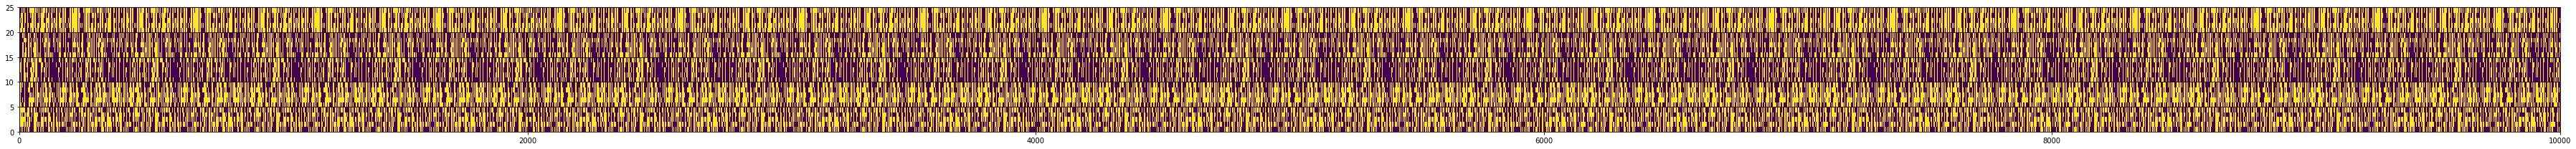

In [8]:
import matplotlib.pyplot as plt

# visualize the simulation
plt.figure(figsize=(50, 3))
plt.pcolor(sims.T)
plt.grid('on', color='k')
plt.tight_layout()
plt.savefig(f"{rho}.png")


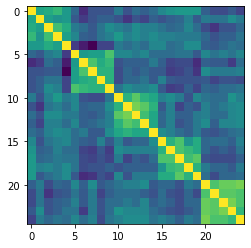

In [9]:
corr_matrix = np.zeros([n_agents]*2)
for i in range(n_agents):
    for j in range(n_agents):
        if i < j:
            corr_matrix[i,j] = 2*np.sum(sims[:, i] == sims[:, j])/n_steps - 1
corr_matrix = corr_matrix + corr_matrix.T + np.identity(n_agents)
fig,ax=pl.subplots()
ax.imshow(corr_matrix)

# Junk

Homogeneous approach alternative:

In [14]:

import numpy as np
import math

def hb(p):
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p) if p > 0 and p < 1 else 0

def calca(nn, r):
    return (math.sqrt((1 - nn) * r**2 + (nn - 2) * r + 1) - r + 1) / r

def calcrho(nn, aa):
    return (nn + 2 * aa) / ((aa + 1) ** 2 + nn - 1)

def gen1(nn, aa):
    y = np.random.normal(0, 1, nn)
    return (np.sum(y) * np.ones(nn) + aa * y) / math.sqrt((aa + 1) ** 2 + (nn - 1))

def tryn(nn, rho, t):
    aa = calca(nn, rho)
    Pk = np.zeros((nn + 1, nn + 1))
    PJk = np.zeros((nn + 1, nn + 1))  # joint prob
    PCk = np.zeros((nn + 1, nn + 1))  # cond prob
    for _ in range(t):
        y = gen1(nn, aa)
        z = np.array([1 if t > 0 else 0 for t in y])
        c = 0
        for k in range(nn):
            c += z[k - 1] if k > 0 else 0
            Pk[k][c] += 1
            if z[k] == 1:
                PJk[k][c] += 1
    # normalize probabilities
    for k in range(nn):
        Pk[k] /= t
        PJk[k] /= t
    for k in range(nn):
        for c in range(k + 1):
            PCk[k][c] = PJk[k][c] / Pk[k][c] if Pk[k][c] > 0 else 0
    r = calcrho(nn, aa)
#     print(f"{nn=} {r=} {aa=} {t=}")
    # print(np.round(Pk[:5,:5],5))
    # print(np.round(PJk[:5,:5],5))
    # print(np.round(PCk,5))
    H = np.zeros(nn)
    for k in range(nn):
        H[k] = 0
        for c in range(k + 1):
             H[k] += hb(PCk[k][c]) * Pk[k][c]
    print('h', np.round(H, 5))

rho = 0.7
nn = 12
tryn(nn, rho, 800000)

h [1.      0.81577 0.74309 0.70437 0.67853 0.66139 0.64927 0.63884 0.63239
 0.6242  0.62141 0.61609]


In [15]:
#old attempt at Homogeneous case

In [16]:
from scipy.special import comb
def tcomb(n,k):
    return comb(n,k,exact=False)

In [17]:
def tcomb(n,k):
    return comb(n,k,exact=False)
type(tcomb(1,1))

numpy.float64

In [18]:
k=0
r=0
tcomb(k-1,r) - ((-1)**((k+2*r-1)/2))*tcomb(k-1,(k-1)/2)

0j

In [19]:
def get_crk_arr(N):
    crk=np.zeros((N+1,N+1))
    for k in range(1,N+1,2): #skip k=0 since gives 0 imaginary and is zero anyway
        for r in range(k+1):
            crk[r,k]=tcomb(k-1,r) - ((-1)**((k-1)/2+r))*tcomb(k-1,(k-1)/2)
    return crk
def pkk_even(m,rho):
    return np.power(2*np.pi,-m)/(1+2*m*rho/(1-rho)) #*np.sqrt(np.pi/2)
def pkk_odd(k,prk_arr,crk_arr):
    k=int(k)
    assert k%2, "k not odd!"
    tmpsum=0
    for r in range(int((k+1)/2),k):
        tmpsum+=crk_arr[r,k]*prk_arr[r,k-1]
    return ((-1)**((k-1)/2))*(0.5-tmpsum)/tcomb(k-1,(k-1)/2)

In [20]:
N=5
rho=0.01
crk_arr=get_crk_arr(N)
prk_arr=np.zeros((N+1,N+1))    
for k in range(N+1):
    prk_arr[k,k]=pkk_odd(k,prk_arr,crk_arr) if k%2 else pkk_even(k/2,rho)  
    for r in np.arange(k)[::-1]:
        prk_arr[r,k]=1/2 if k==1 else prk_arr[r,k-1]-prk_arr[r+1,k]
# test
for k in range(N+1):
    print(np.sum(np.array([tcomb(k,r) for r in range(k+1)])*prk_arr[:k+1,k]))

1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999


In [21]:
np.set_printoptions(linewidth=np.Inf)

In [22]:
1%2

1

In [23]:
prk_arr

array([[ 1.        ,  0.5       ,  0.15600336, -0.01599496,  0.0243466 ,  0.17085809],
       [ 0.        ,  0.5       ,  0.34399664,  0.17199832, -0.04034156, -0.14651149],
       [ 0.        ,  0.        ,  0.15600336,  0.17199832,  0.21233987,  0.10616994],
       [ 0.        ,  0.        ,  0.        , -0.01599496, -0.04034156,  0.10616994],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.0243466 , -0.14651149],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.17085809]])

In [24]:
entropy=np.sum(np.asarray[tcomb(k,r) for r in range(r)])*prk_arr[])

SyntaxError: invalid syntax (<ipython-input-24-d74236eea915>, line 1)

In [ ]:
k=3
tcomb(k,np.arange(1,k))